In [1]:
import numpy as np
import pandas as pd
import random as rand
from scipy import linalg
from scipy.sparse.linalg import eigs, LinearOperator
from scipy.sparse import random
from scipy.optimize import brute
import scipy.stats as stats
from os import listdir,getcwd
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import OrderedDict
import pandas as pd
%matplotlib inline


In [2]:
zhang_dir = getcwd()+'\\ZhangData'
data = np.zeros(132, dtype=[('neuron_id','a13'),
                                ('raster_data',np.float32,(419,1000)),
                                ('raster_info','a20',4),
                                ('stimulus_id','a15',419),
                                ('stimulus_position','a15',419),
                                ('combined_id_position','a15',419)])

for i,data_dir in enumerate(listdir(zhang_dir)):
    raster_data, raster_info, raster_labels = [zhang_dir+'\\'+data_dir+'\\'+my_dir for my_dir in listdir(zhang_dir+'\\'+data_dir)]
    neuron_id = data_dir[0:(len(data_dir)-12)]
    data_arr = pd.read_csv(raster_data,header=None).values
    labels_arr = pd.read_csv(raster_labels,header=0).values
    if data_arr.shape == (420,1000):
        data_arr = data_arr[0:(len(data_arr)-1)]
        labels_arr = labels_arr[0:(len(labels_arr)-1)]
    data[i] = (neuron_id, data_arr, pd.read_csv(raster_info).values, labels_arr[:,0],labels_arr[:,1],labels_arr[:,2])

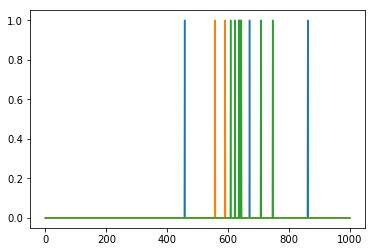

['bp1001spk_01A', 'bp1001spk_02A', 'bp1001spk_03A']

In [3]:
[x[0]  for x in data[['neuron_id']][0:3]]

#Get fourth run from first 3 neurons
[plt.plot(x[0][4]) for x in data[['raster_data']][0:3]]
plt.show()
[x[0] for x in data[['neuron_id']][0:3]]

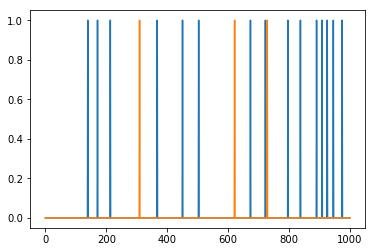

In [48]:
## for multiple neurons
y=[x['raster_data'][x[0]=='hand'] for x in data[['stimulus_id','raster_data']][:][:]]
plt.plot(y[0][0])
plt.plot(y[0][1])
plt.show()
#for single neurons
#[x[:,0] for x in data[['stimulus_id','raster_data']][0][0]]

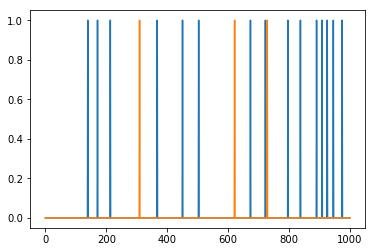

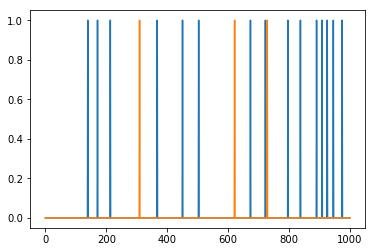

In [53]:
[plt.plot(x) for x in data['raster_data'][0][data['stimulus_id'][0]=='hand'][0:2]]
plt.show()
[plt.plot(x) for x in data['raster_data'][0][[0,9],:]]
plt.show()

In [10]:
def addExponentialDecayToNeuronRead(neuron_read, rate_of_exp_decrease):
    activation = 0.0
    for i,x in enumerate(neuron_read):
        if x==1.0:
            activation+=1.0
        elif ((x==0.0) and (activation>0.0)):
            activation *= rate_of_exp_decrease
        if activation<0.:
            activation=0.
        neuron_read[i]=activation


def addExponentialDecay(speed,d=data):
    addExpDecay = partial(addExponentialDecayToNeuronRead, rate_of_exp_decrease = speed)
    for neuron in d:
        np.apply_along_axis(addExpDecay, axis = 1, arr = neuron['raster_data'])

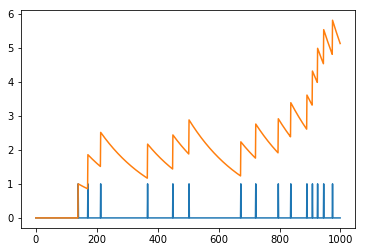

In [55]:
plt.plot(data['raster_data'][0][0,:])
plt.plot(addExponentialDecayToNeuronRead(0.995,data['raster_data'][0][0,:]))
plt.show()

In [3]:
index_1018=data['raster_info'][:,3]=='1018'
index_1018

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [4]:
index_1018=data['raster_info'][:,3]=='1018'
data_1018 = np.zeros(11, dtype=[('neuron_id','a13'),
                                ('raster_data',np.float32,(419,1000)),
                                ('raster_info','a20',4),
                                ('stimulus_id','a15',419),
                                ('stimulus_position','a15',419),
                                ('combined_id_position','a15',419)])
data_1018[np.arange(11)] = data[index_1018]

In [5]:
np.save('data_1018',data_1018)

In [38]:
test_data = data_1018.copy()
addExponentialDecay(0.995,test_data)

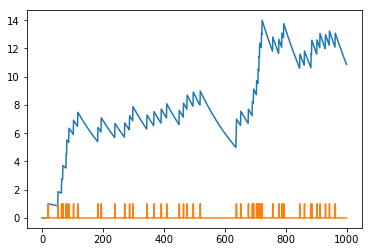

In [22]:
plt.plot(test_data['raster_data'][1][0,:])
plt.plot(data_1018['raster_data'][1][0,:])
plt.show()

In [13]:
def reshapeSignalsToOneTimeTrace(signal):
    (nUnits, nRuns, nTime) = signal.shape
    single_trace_signal = np.zeros((nUnits,nRuns*nTime))
    for i in np.arange(nRuns):
        single_trace_signal[:,(i*nTime):(i*nTime+nTime)] = signal[:,i,:].reshape((nUnits,nTime))
    return(single_trace_signal)

In [28]:
seen = dict(zip(np.unique(data['raster_info'][:,3]),np.zeros(21)))
for runid in data['raster_info'][:,3]:
    seen[runid] = seen[runid]+1
    
seen

{'1001': 4.0,
 '1002': 4.0,
 '1003': 6.0,
 '1004': 5.0,
 '1005': 6.0,
 '1006': 7.0,
 '1007': 5.0,
 '1008': 5.0,
 '1009': 6.0,
 '1010': 6.0,
 '1011': 5.0,
 '1012': 5.0,
 '1013': 5.0,
 '1014': 6.0,
 '1015': 9.0,
 '1016': 6.0,
 '1017': 7.0,
 '1018': 11.0,
 '1019': 8.0,
 '1020': 8.0,
 '1021': 8.0}

In [51]:
teach = createTeacherSignal(data_1018)[0]

Number of output nodes: 7
Stimulus shown: guitar


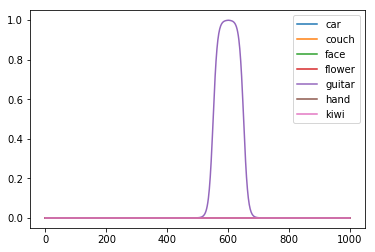

In [27]:
names=['car', 'couch', 'face', 'flower', 'guitar', 'hand', 'kiwi']
stim_num = 8
x = [plt.plot(x[stim_num,:], label = names[i]) for i,x in enumerate(teach)]
print('Number of output nodes: '+str(len(x)))
print('Stimulus shown: '+data_1018[0]['stimulus_id'][stim_num])
plt.legend()
plt.show()

In [39]:
teach_test = reshapeSignalsToOneTimeTrace(teach)
one_signal_data_test = reshapeSignalsToOneTimeTrace(test_data['raster_data'])

In [40]:
teach_test.shape
one_signal_data_test.shape

(11L, 419000L)

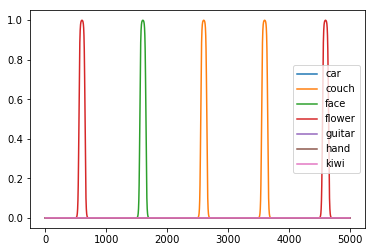

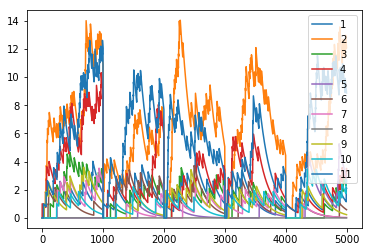

In [41]:
x = [plt.plot(x, label = names[i]) for i,x in enumerate(teach_test[:,0:5000])]
plt.legend()
plt.show()

neuron_ids = ['1','2','3','4','5','6','7','8','9','10','11']
x = [plt.plot(x,label = neuron_ids[i]) for i,x in enumerate(one_signal_data_test[:,0:5000])]
plt.legend()
plt.show()

In [6]:
def getSpecificStimulus(sid, neuron_index = None, d=data):
    if neuron_index==None:
        to_return = [x['raster_data'][x[0]==sid] for x in d[['stimulus_id','raster_data']][:][:]]
    else:
        to_return = [x['raster_data'][x[0]==sid] for x in d[['stimulus_id','raster_data']][neuron_index][:]]
    return(to_return)

def addExponentialDecayToNeuronRead(neuron_read, rate_of_exp_decrease):
    activation = 0.0
    for i,x in enumerate(neuron_read):
        if x==1.0:
            activation+=1.0
        elif ((x==0.0) and (activation>0.0)):
            activation *= rate_of_exp_decrease
        if activation<0.:
            activation=0.
        neuron_read[i]=activation

def addExponentialDecay(speed,d=data):
    addExpDecay = partial(addExponentialDecayToNeuronRead, rate_of_exp_decrease = speed)
    for neuron in d:
        np.apply_along_axis(addExpDecay, axis = 1, arr = neuron['raster_data'])
    np.max(d['raster_data'])

def createBriefTeacherSignal(d=data):
    ind_dict = dict(zip(['car', 'couch', 'face', 'flower', 'guitar', 'hand', 'kiwi'],np.arange(7)))
    teacher_signal = np.zeros(len(d), dtype = (np.float32,(7,419,1000)))
    increase = [1.0/(1.0+np.exp(-0.7*x)) for x in np.linspace(-10,10,100)]
    decrease = [1.0/(1.0+np.exp(0.7*x)) for x in np.linspace(-10,10,100)]
    for i, neuron in enumerate(d):
        for j in np.arange(419):
            stimulus_index = ind_dict[neuron['stimulus_id'][j]]
            stimulus_shown = int(neuron['raster_info'][0])
            teacher_signal[stimulus_index][i][stimulus_shown:stimulus_shown+100] = increase
            teacher_signal[stimulus_index][i][stimulus_shown+100:stimulus_shown+200] = decrease

    return (teacher_signal)

def createExtendedTeacherSignal(d=data):
    ind_dict = dict(zip(['car', 'couch', 'face', 'flower', 'guitar', 'hand', 'kiwi'],np.arange(7)))
    teacher_signal = np.zeros(len(d), dtype = (np.float32,(7,419,1000)))
    increase = [1.0/(1.0+np.exp(-0.7*x)) for x in np.linspace(-10,10,100)]
    for i, neuron in enumerate(d):
        for j in np.arange(419):
            stimulus_index = ind_dict[neuron['stimulus_id'][j]]
            stimulus_shown = int(neuron['raster_info'][0])
            teacher_signal[stimulus_index][i][stimulus_shown:(stimulus_shown+100)] = increase
            teacher_signal[stimulus_index][i][(stimulus_shown+100):1000] = 1.0

    return (teacher_signal)

def createTimeSensitiveTeacherSignal(d=data, num_bins = 10):
    ind_dict = dict(zip(['car', 'couch', 'face', 'flower', 'guitar', 'hand', 'kiwi'],np.arange(7)))
    teacher_signal = np.zeros((7*num_bins,419,1000))
    neuron = d[0]
    for j in np.arange(419):
        stimulus_num = ind_dict[neuron['stimulus_id'][j]]
        start_index = stimulus_num*num_bins
        stimulus_shown = int(neuron['raster_info'][0])
        bin_size = int((1000-stimulus_shown)/num_bins)
        for i in np.arange(start_index,start_index+num_bins):
            start = stimulus_shown+(i%num_bins)*bin_size
            teacher_signal[i,j,start:start+bin_size] = 1.0
    return (teacher_signal)    

def reshapeSignalsToOneTimeTrace(signal):
    (nUnits, nRuns, nTime) = signal.shape
    single_trace_signal = np.zeros((nUnits,nRuns*nTime))
    for i in np.arange(nRuns):
        single_trace_signal[:,(i*nTime):(i*nTime+nTime)] = signal[:,i,:].reshape((nUnits,nTime))
    return(single_trace_signal)

def calculateTotalAccuracy(y_target,y,nToSkip = 100):
    n_outputs = int(y_target.shape[0])
    n_bins = n_outputs/7
    n_time_steps = int(y_target.shape[1])
    n_cases = n_time_steps/1000
    added_traces = np.zeros((7,500))
    predicted = np.zeros(n_bins)
    total_acc = 0
    bin_acc = np.zeros(n_bins)
    incorrect = 0
    cols = ['r','b','g','y', 'c', 'm', 'k']
    stimuli_range = np.arange(7)*n_bins
    for j in np.arange((1000-nToSkip)%1000,n_time_steps,1000):
        for i in np.arange(7):
            added_traces[i] = reduce(lambda a,b: a+b, y[i*n_bins:i*n_bins+n_bins,j+500:j+1000])
        predicted = [np.argmax(np.sum(y[:,j+500+(i*500/n_bins):j+500+(i*500/n_bins)+(500/n_bins)],axis=1)) for i in np.arange(n_bins)]       
        #predicted = [np.argmax(np.sum(y[:,j+500:j+500+(i*500/n_bins)+(500/n_bins)],axis=1)) for i in np.arange(n_bins)]       
        full_predicted = np.argmax(np.sum(added_traces,axis=1))
        correct=np.argmax([1. in i for i in y_target[:,j+500:j+1000]])/n_bins
        correct_list = np.arange(correct*n_bins,correct*n_bins+n_bins)
        if int(correct)==full_predicted:
            total_acc=total_acc+1
        else:
            incorrect=incorrect+1
        bin_acc+=[1. if correct_list[i]==predicted[i] else 0. for i in np.arange(n_bins) ]
        
    tot_runs = total_acc+ incorrect
    return(float(total_acc)/float(tot_runs),bin_acc/tot_runs)

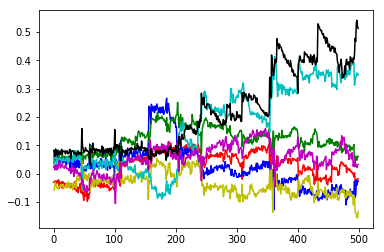

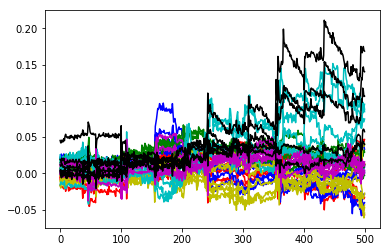

In [39]:
added_traces = np.zeros((7,500))
for i in np.arange(7):
    added_traces[i] = reduce(lambda a,b: a+b, Y[i*35/7:i*35/7+35/7,500:1000])
[plt.plot(trace,c=cols[i]) for i,trace in enumerate(added_traces)]
plt.show()
[plt.plot(trace, c= rep_cols[i]) for i,trace in enumerate(Y[:,500:1000])]
plt.show()

In [7]:
seed = 275 # 275, 276, 300
nTimeUnits = 1000
nTrainRuns = 300
nTestRuns = 419-nTrainRuns
nToSkip = 12000
inputSize = 12
num_bins = 5

rand.seed(seed) # set the seed
np.random.seed(seed)
rvs = stats.uniform(-1,2).rvs # uniform distribution between [-1,1]

In [8]:
tot_corr = 0
tot_test_corr = 0

cols = ['r','b','g','y', 'c', 'm', 'k']
rep_cols = np.repeat(cols,num_bins)

labs = ['car', 'couch', 'face', 'flower', 'guitar', 'hand', 'kiwi']
rep_labs = np.repeat(labs,num_bins)

%matplotlib auto

Using matplotlib backend: Qt5Agg


In [9]:
# Tunable parameters
res_size = 100
scale_res = 0.6
alpha = 4.5 # regularization rate
scale_in = 2.3
scale_b = 1.0
scale_noise = 0.
exp_decay_rate = 0.995
scale_input_data = True

In [10]:
# Preparing input and teacher data
data_exp_decay_1018 = data_1018.copy()
addExponentialDecay(exp_decay_rate,data_exp_decay_1018)
if scale_input_data:
    data_exp_decay_1018['raster_data']/=np.max(data_exp_decay_1018['raster_data'])
input_data = np.concatenate((np.ones((1,419,1000)),data_exp_decay_1018['raster_data']),axis=0) # vertically concatenate ones as first input

In [11]:
# Create output signal 
teacher = createTimeSensitiveTeacherSignal(data_1018, num_bins = num_bins) # Because each of these 11 neurons saw the same stimuli, only need one

In [12]:
W = random(res_size,res_size,density = 0.1, data_rvs = rvs).A # uniformly distributed
vals, vecs = np.absolute(eigs(W))
l = max(vals) # eigenvalues
W /= l # divide W by it's largest eigenvalue
W *= scale_res # scale W

W_in = random(res_size,inputSize,density=0.1, data_rvs = rvs).A
W_in *= scale_in

b = np.array(rvs(res_size)).reshape(res_size,1)
b *= scale_b

## State Harvesting
X = np.zeros((res_size,nTrainRuns*nTimeUnits))
M = np.zeros((res_size+inputSize,nTrainRuns*nTimeUnits-nToSkip))
T = np.zeros((7*num_bins,nTrainRuns*nTimeUnits-nToSkip))

for run in np.arange(nTrainRuns):
    for i in np.arange(1, nTimeUnits):
        index = run*nTimeUnits+i
        W_dot_Xn = np.dot(W,X[:,index-1].reshape((res_size,1)))
        Win_dot_Un = np.dot(W_in, input_data[:,run,i].reshape((inputSize,1)))
        noise = np.random.normal(0,scale_noise,size=res_size).reshape((res_size,1))
        X[:,index] = np.tanh(W_dot_Xn+Win_dot_Un+b+noise).reshape(res_size)
        if index >=nToSkip:
            M[:,index-nToSkip]=np.concatenate((input_data[:,run,i],X[:,index]),axis=0)
            T[:,index-nToSkip]=teacher[:,run,i].reshape(7*num_bins)
#Y_dot_Xt = reduce(lambda x,y:x+y, [np.dot(subset_teacher[:,i,:].reshape(70,1000),X[i*1000:i*1000+1000,:].T) for i in np.arange(419)])
Y_dot_Xt = np.dot(T,M.T)
X_dot_Xt_w_regularization = np.dot(M,M.T)+alpha*np.identity(res_size+inputSize)

# Use Ridge Regression to calculate output Weights
W_out = np.dot(Y_dot_Xt, linalg.inv(X_dot_Xt_w_regularization))
Y = np.dot(W_out,M)

In [ ]:
prev_tot_corr = tot_corr
[tot_corr,bin_corr] = calculateTotalAccuracy(T,Y,nToSkip)

inv_leg = Rectangle((0, 0), 0, 0, alpha=0.0)

f, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2,3)
[ax1.plot(np.arange(1000,2000),X[i,1000:2000]) for i in np.arange(1,5)]
ax1.set_title("Subset Reservoir Dynamics 1-4")

[ax4.plot(X[i,:]) for i in np.arange(1,5)]
ax4.set_title("Full Reservoir Dynamics 1-4")

[ax2.plot(np.arange(0,10000),T[i,0:10000],c=rep_cols[i],label = rep_labs[i]) for i in np.arange(7*num_bins)]
[ax2.plot(np.arange(0,10000),Y[i,0:10000],c=rep_cols[i],label = rep_labs[i]) for i in np.arange(7*num_bins)]
ax2.set_title("Teacher & Training Output - Cases 1-10")
handles, labels = ax2.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax2.legend(by_label.values(), by_label.keys(), loc=3,
           ncol=7, mode="expand", borderaxespad=0., handlelength=0.5,handletextpad =0.0)

[ax5.plot(np.arange(10000,20000),T[i,10000:20000],c=rep_cols[i],label = rep_labs[i]) for i in np.arange(7*num_bins)]
[ax5.plot(np.arange(10000,20000),Y[i,10000:20000],c=rep_cols[i],label = rep_labs[i]) for i in np.arange(7*num_bins)]
ax5.set_title("Teacher & Training Output Cases 11-20")
handles, labels = ax5.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax5.legend(by_label.values(), by_label.keys(), loc=3,
           ncol=7, mode="expand", borderaxespad=0., handlelength=0.5,handletextpad =0.0)


[ax3.plot(np.arange(8000,9050),T[i,8000:9050],c=cols[i%num_bins],label = labs[i/num_bins]) for i in np.arange(6*num_bins,7*num_bins)]
[ax3.plot(np.arange(8000,9050),Y[i,8000:9050],c=cols[i%num_bins],label = labs[i/num_bins]) for i in np.arange(6*num_bins,7*num_bins)]
ax3.set_title("8th Train Case Model Output")
handles, labels = ax3.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax3.legend([inv_leg], by_label.keys(), handlelength=0.)

[ax6.plot(np.arange(13000,14050),T[i,13000:14050],c=cols[i%num_bins],label = labs[i/num_bins]) for i in np.arange(4*num_bins,5*num_bins)]
[ax6.plot(np.arange(13000,14050),Y[i,13000:14050],c=cols[i%num_bins],label = labs[i/num_bins]) for i in np.arange(4*num_bins,5*num_bins)]
ax6.set_title("13th Train Case Model Output")
handles, labels = ax6.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax6.legend([inv_leg], by_label.keys(), handlelength=0.)

plt.suptitle('Overall Training Accuracy: '+str(tot_corr) + ", Change: "+str(tot_corr-prev_tot_corr)+ 
             ", Time Binned Accuracies: "+str(np.round(bin_corr,3)))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
mng = plt.get_current_fig_manager()
mng.window.showMaximized()
plt.show()

In [ ]:
X_test = np.zeros((res_size,nTestRuns*nTimeUnits))
M_test = np.zeros((res_size+inputSize,nTestRuns*nTimeUnits))
T_test = np.zeros((7*num_bins,nTestRuns*nTimeUnits))

for run in np.arange(nTestRuns):
    for i in np.arange(1, nTimeUnits):
        index = run*nTimeUnits+i
        run_index = run + nTrainRuns
        W_dot_Xn = np.dot(W,X_test[:,index-1].reshape((res_size,1)))
        Win_dot_Un = np.dot(W_in, input_data[:,run_index,i].reshape((inputSize,1)))
        noise = np.random.normal(0,scale_noise,size=res_size).reshape((res_size,1))
        X_test[:,index] = np.tanh(W_dot_Xn+Win_dot_Un+b+noise).reshape(res_size)
        M_test[:,index]=np.concatenate((input_data[:,run_index,i],X_test[:,index]),axis=0)
        T_test[:,index]=teacher[:,run_index,i].reshape(7*num_bins)

Y_test=np.dot(W_out,M_test)

In [ ]:
prev_tot_test_corr = tot_test_corr
[tot_test_corr,bin_test_corr] = calculateTotalAccuracy(T_test,Y_test,0)

f, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2,3)
[ax1.plot(np.arange(1000,2000),X_test[i,1000:2000]) for i in np.arange(1,5)]
ax1.set_title("Subset Reservoir Dynamics 1-4")

[ax4.plot(X_test[i,:]) for i in np.arange(1,5)]
ax4.set_title("Full Reservoir Dynamics 1-4")

#iplot([go.Scatter(x=np.arange(len(trace)),y=trace) for trace in X_test[0:3,:]])
cols = ['r','b','g','y', 'c', 'm', 'k']
rep_cols = np.repeat(cols,num_bins)

labs = ['car', 'couch', 'face', 'flower', 'guitar', 'hand', 'kiwi']
rep_labs = np.repeat(labs,num_bins)

[ax2.plot(np.arange(0,10000),T_test[i,0:10000],c=rep_cols[i],label = rep_labs[i]) for i in np.arange(7*num_bins)]
[ax2.plot(np.arange(0,10000),Y_test[i,0:10000],c=rep_cols[i],label = rep_labs[i]) for i in np.arange(7*num_bins)]
ax2.set_title("Teacher & Testing Output - Cases 1-10")
handles, labels = ax2.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax2.legend(by_label.values(), by_label.keys(), loc=3,
           ncol=7, mode="expand", borderaxespad=0., handlelength=0.5,handletextpad =0.0)

[ax5.plot(np.arange(10000,20000),T_test[i,10000:20000],c=rep_cols[i],label = rep_labs[i]) for i in np.arange(7*num_bins)]
[ax5.plot(np.arange(10000,20000),Y_test[i,10000:20000],c=rep_cols[i],label = rep_labs[i]) for i in np.arange(7*num_bins)]
ax5.set_title("Teacher & Testing Output Cases 11-20")
handles, labels = ax5.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax5.legend(by_label.values(), by_label.keys(), loc=3,
           ncol=7, mode="expand", borderaxespad=0., handlelength=0.5,handletextpad =0.0)


[ax3.plot(np.arange(8000,9050),T_test[i,8000:9050],
          c=cols[i%num_bins],label = labs[i/num_bins]) for i in np.arange(3*num_bins,4*num_bins)]
[ax3.plot(np.arange(8000,9050),Y_test[i,8000:9050],
          c=cols[i%num_bins],label = labs[i/num_bins]) for i in np.arange(3*num_bins,4*num_bins)]
ax3.set_title("8th Test Case Model Output")
handles, labels = ax3.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax3.legend([inv_leg], by_label.keys(), handlelength=0.)

[ax6.plot(np.arange(13000,14050),T_test[i,13000:14050],
          c=cols[i%num_bins],label = labs[i/num_bins]) for i in np.arange(3*num_bins,4*num_bins)]
[ax6.plot(np.arange(13000,14050),Y_test[i,13000:14050],
          c=cols[i%num_bins],label = labs[i/num_bins]) for i in np.arange(3*num_bins,4*num_bins)]
ax6.set_title("13th Test Case Model Output")
handles, labels = ax6.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax6.legend([inv_leg], by_label.keys(), handlelength=0.)

plt.suptitle('Overall Testing Accuracy: '+str(tot_test_corr) + ", Change: "+str(tot_test_corr-prev_tot_test_corr)+ 
             ", Time Binned Accuracies: "+str(np.round(bin_test_corr,3)))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
mng = plt.get_current_fig_manager()
mng.window.showMaximized()
plt.show()

In [ ]:
dfm=pd.read_csv('parameter_history.csv', header=0)
parameter_names = ['scale_input_data','num_bins','res_size','scale_res','alpha','scale_in','scale_b','scale_noise',
                   'exp_decay_rate','tot_corr','bin_corr','tot_test_corr','bin_test_corr']
parameter_vals = [scale_input_data,num_bins,res_size,scale_res,alpha,scale_in,scale_b,
                  scale_noise,exp_decay_rate,tot_corr,bin_corr,tot_test_corr,bin_test_corr]
dfm.append(dict(zip(parameter_names,parameter_vals)))
dfm.to_csv('parameter_history.csv')